In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

import socket

import os

# check for GPU availability
if socket.gethostname() in ["txori", "pakhi"]:
    import GPUtil
    deviceIDs = GPUtil.getAvailable()
    if len(deviceIDs) < 1:
        GPUtil.showUtilization()
        print("No GPUs available")
        deviceID = ''
    else:
        deviceID = deviceIDs[0]
        print("Using GPU: {}".format(deviceID))
    # set device ID
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(deviceID)

Using GPU: 0


### Self contained tensorflow 2.0 notebook for feature / class visualization in convnets
- This is a self contained notebook capturing some core ideas from feature and class visualization in neural networks, and applying some ideas of my own. 

References I used:
- https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow
- https://gist.github.com/RaphaelMeudec/31b7bba0b972ec6ec80ed131a59c5b3f#file-kernel_visualization-py
- https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
- https://distill.pub/2017/feature-visualization/
- https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/5.4-visualizing-what-convnets-learn.nb.html

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings
warnings.filterwarnings('ignore')
tf.autograph.set_verbosity(0)

In [4]:
# Create a connection between the input and the target layer
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True, classes=1000)

In [5]:
# look at the layers of the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### get model classes

In [6]:
from tensorflow.keras.applications.vgg16 import decode_predictions
import pandas as pd

In [7]:
classes = pd.DataFrame(
    [
        list([j[0] for j in i])
        for i in np.array(
            decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)
        ).T
    ]
).T
classes.columns = ["", "label_", "index_"]
classes['index_'] = np.int32(classes['index_'].values)
classes = classes.sort_values(by="index_")
class_list = classes.label_.values
classes[:3]

,,label_,index_
999,n01440764,tench,0
998,n01443537,goldfish,1
997,n01484850,great_white_shark,2


In [8]:
class_list#[:10]

array(['tench', 'goldfish', 'great_white_shark', 'tiger_shark',
       'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich',
       'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting',
       'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel',
       'kite', 'bald_eagle', 'vulture', 'great_grey_owl',
       'European_fire_salamander', 'common_newt', 'eft',
       'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog',
       'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle',
       'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana',
       'American_chameleon', 'whiptail', 'agama', 'frilled_lizard',
       'alligator_lizard', 'Gila_monster', 'green_lizard',
       'African_chameleon', 'Komodo_dragon', 'African_crocodile',
       'American_alligator', 'triceratops', 'thunder_snake',
       'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake',
       'garter_snake', 'water_snake', 'vine_snake', 'night_snake',
     

#### normalization functions

In [9]:
def zero_one_norm(x):
    return (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x))
def z_score(x, scale = 1.0):
    return (x - tf.reduce_mean(x)) / (tf.math.reduce_std(x)/scale)
def norm(x):
    return zero_one_norm(z_score(x))
def soft_norm(x, n_std = 15):
    """ zscore and set n_std range of 0-1, then clip
    """
    x = z_score(x) / (n_std*2)
    return tf.clip_by_value(x + 0.5, 0, 1)

In [10]:
def adjust_hsv(imgs, sat_exp = 2.0, val_exp = 0.5):
    """ normalize color for less emphasis on lower saturation
    """
    # convert to hsv
    
    hsv = tf.image.rgb_to_hsv(imgs)
    hue, sat, val = tf.split(hsv, 3, axis=2)
    
    # manipulate saturation and value
    sat = tf.math.pow(sat,sat_exp)
    val = tf.math.pow(val,val_exp)
    # rejoin hsv
    hsv_new = tf.squeeze(tf.stack([hue, sat, val], axis=2), axis = 3)
    
    # convert to rgb
    rgb = tf.image.hsv_to_rgb(hsv_new)
    return rgb

#### functions for initializing noise

In [11]:
def gen_noise(dim=244, nex = 1):
    """ Generate some noise to initialize
    """
    input_img_data = tf.random.uniform((nex, dim, dim, 3))
    return tf.Variable(tf.cast(input_img_data, tf.float32))

#### functions for optimization

In [12]:
def get_opt_function():
    """ This function returns the optimizer function. This is just necessary because of tensorflow weirdness. 
    See: https://github.com/tensorflow/tensorflow/issues/27120#issuecomment-540071844
    """
    @tf.function
    def opt(
        submodel,
        input_data,
        filter_index,
        optimizer,
        steps=100,
        lr=0.01,
        layer_dims=2,
        soft_norm_std=15,
        norm_f = "soft_norm",
        normalize_grads = True
    ):
        """ This function runs a single optimization over the list of images
        """
        # determine if this is a convolutional, or fully connected layer
        if layer_dims == 2:
            # identity function because second dimension is already the filter dimension
            loss_func = lambda out_: out_
        if layer_dims == 4:
            # flip to make filter dimension second dimension
            loss_func = lambda out_: tf.transpose(out_, perm = [0,3,1,2])
        # optimization
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(input_data)
                
                if norm_f == "sigmoid":
                    outputs = submodel(tf.nn.sigmoid(input_data))
                else:
                    outputs = submodel(input_data)
                outputs = loss_func(outputs)

                loss_value = tf.gather_nd(
                    outputs, indices=filter_index, batch_dims=0, name=None
                )
                grads = tape.gradient(loss_value, input_data)
                
                if normalize_grads:
                    norm_divisor = tf.expand_dims(
                        tf.expand_dims(
                            tf.expand_dims(tf.math.reduce_std(grads, axis=[1, 2, 3]), 1), 1
                        ),
                        1,
                    )

                    normalized_grads = grads / norm_divisor
                    optimizer.apply_gradients(zip([-normalized_grads], [input_data]))
                else: 
                    optimizer.apply_gradients(zip([-grads], [input_data]))
                    
                if norm_f == "clip":
                    input_data.assign(tf.clip_by_value(input_data, 0, 1))
                elif norm_f == "soft_norm":
                    input_data.assign(soft_norm(input_data, n_std=soft_norm_std))
                elif norm_f == "sigmoid":
                    input_data.assign(tf.clip_by_value(input_data, -50, 50))
                    # normalizes color channels to sit scale roughly uniform
                    input_data.assign(z_score(input_data, scale=1.5))
                    
                    
        return input_data, 0
        
    return opt

In [13]:
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import gaussian

def upscale_image(imgs, upscaling_factor=1.1, sigma=0):
    """ Upsample and smooth the list of images
    """
    img_list = []
    for img in imgs:
        if upscaling_factor == 1.0:
            upscaled_img = img
        else:
            sz = np.array(np.shape(img))[0]
            sz_up = (upscaling_factor * sz).astype("int")
            lower = int(np.floor((sz_up - sz) / 2))
            upper = int(np.ceil((sz_up - sz) / 2))

            upscaled_img = resize(img.astype("float"), (sz_up, sz_up), anti_aliasing=True)
            upscaled_img = upscaled_img[
                lower:-lower, lower:-lower, :,
            ]
        if sigma > 0:
            upscaled_img = gaussian(upscaled_img, sigma=sigma, multichannel=True)
        img_list.append(upscaled_img)
    return tf.Variable(tf.cast(np.array(img_list), tf.float32))

In [14]:
def optimize_filter(
    submodel,
    layer_name,
    filter_index,
    filters_shape,
    steps=20,
    lr=0.01,
    layer_dims=2,
    n_upsample=1,
    sigma=0,
    upscaling_factor=1.1,
    soft_norm_std=15,
    single_receptive_field=True,
    norm_f = "soft_norm",
    normalize_grads = True
):
    """ This pulls together the steps for optimizing the image, and upsampling
    """

    opt = get_opt_function()
    optimizer = tf.keras.optimizers.Adam(lr)

    # subset center neuron if we only want to look at one receptive field
    if single_receptive_field & (layer_dims == 4):
        filter_index = [
            [i[0], i[1], int(filters_shape[1] / 2), int(filters_shape[2] / 2)]
            for i in filter_index
        ]
        
    loss_list = []
    # list of outputs during optimization
    output_images = []
    # generate initial noise
    img_data = gen_noise(nex=len(filter_index))
    output_images.append(img_data.numpy())
    
    # apply optimization
    for i in tqdm(range(n_upsample), leave=False):
        
        # optimize
        img_data, loss = opt(
            submodel,
            img_data,
            filter_index,
            optimizer=optimizer,
            steps=steps,
            lr=lr,
            layer_dims=layer_dims,
            soft_norm_std=soft_norm_std,
            norm_f = norm_f,
            normalize_grads=normalize_grads
        )        
        
        loss_list.append(np.mean(loss.numpy()))
        output_images.append(img_data.numpy())
        
        # upsample
        if i < (n_upsample - 1):
            img_data = upscale_image(
                img_data.numpy(), upscaling_factor=upscaling_factor, sigma=sigma,
            )
    
    # brg to rgb color channel conversion
    if norm_f == "sigmoid":
        output_images = [tf.nn.sigmoid(i).numpy()[:,:,:,::-1] for i in output_images]
    else:
        output_images = [i[:,:,:,::-1] for i in output_images]

    return output_images, loss_list

### run optimization

In [15]:
def get_class_index(classes, class_list):
    """ grabs the index in the predication layer of the network
        based on the class name
    """
    filter_index = [np.where(class_list == i)[0][0] for i in classes]
    return filter_index

In [16]:
filter_names = ['ostrich', 'bullfrog', 'goldfish', 'monarch', 'red_fox', 'tiger_shark', 'tarantula', 'flamingo'] 
filter_index = get_class_index(filter_names, class_list)

layer_name = "predictions"

filter_index = [[i, j] for i, j in enumerate(filter_index)]

# get module of input/output
submodel = tf.keras.models.Model(
    [model.inputs[0]], [model.get_layer(layer_name).output]
)

filters_shape = submodel.outputs[0].shape
output_images, loss_list = optimize_filter(
    submodel,
    layer_name,
    filter_index,
    filters_shape=filters_shape,
    steps = 20, # how many training steps to perform
    lr=0.1, # gradient step size 
    layer_dims=len(submodel.outputs[0].shape), # how many dimensions the output layer is (2 for fully connected, 4 for convolutional)
    n_upsample=50, # how many steps to upsample
    sigma=1.0, # the amount of blurring to perform when upsampling
    upscaling_factor=1.01, # how much to upsample by
    single_receptive_field=False, # whether to optimize a single neuron, or optimize over the layer
    norm_f = "sigmoid", # how to normalize/color channels between 0 and 1 (clip, sigmoid, )
    soft_norm_std = 3, # the number of standard deviations to clip if norm_f is soft_norm (lower = more saturated)
    normalize_grads=True
    
)

W0520 11:33:16.964366 140153795327808 network.py:847] Model was constructed with shape Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32) for input (None, 224, 224, 3), but it was re-called on a Tensor with incompatible shape (8, 244, 244, 3).
W0520 11:33:17.193934 140153795327808 network.py:847] Model was constructed with shape Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32) for input (None, 224, 224, 3), but it was re-called on a Tensor with incompatible shape (8, 244, 244, 3).


In [17]:
def display_features(output_images, filter_titles=None, ncols=10, zoom = 5, sat_exp=2.0, val_exp = 1.0):
    nrows = int(np.ceil(len(output_images[-1]) / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5,nrows*5))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace = 0.1, wspace = 0.01)
    for axi, ax in enumerate(axs.flatten()):
        if filter_titles is not None:
            if axi < len(filter_titles):
                ax.set_title(filter_titles[axi], fontsize=20)
        ax.axis('off')

    for i in range(len(output_images[-1])):
        ax = axs.flatten()[i]
        rgb = adjust_hsv(output_images[-1][i], sat_exp = sat_exp, val_exp = val_exp)
        pt = ax.imshow(rgb)
    plt.show()

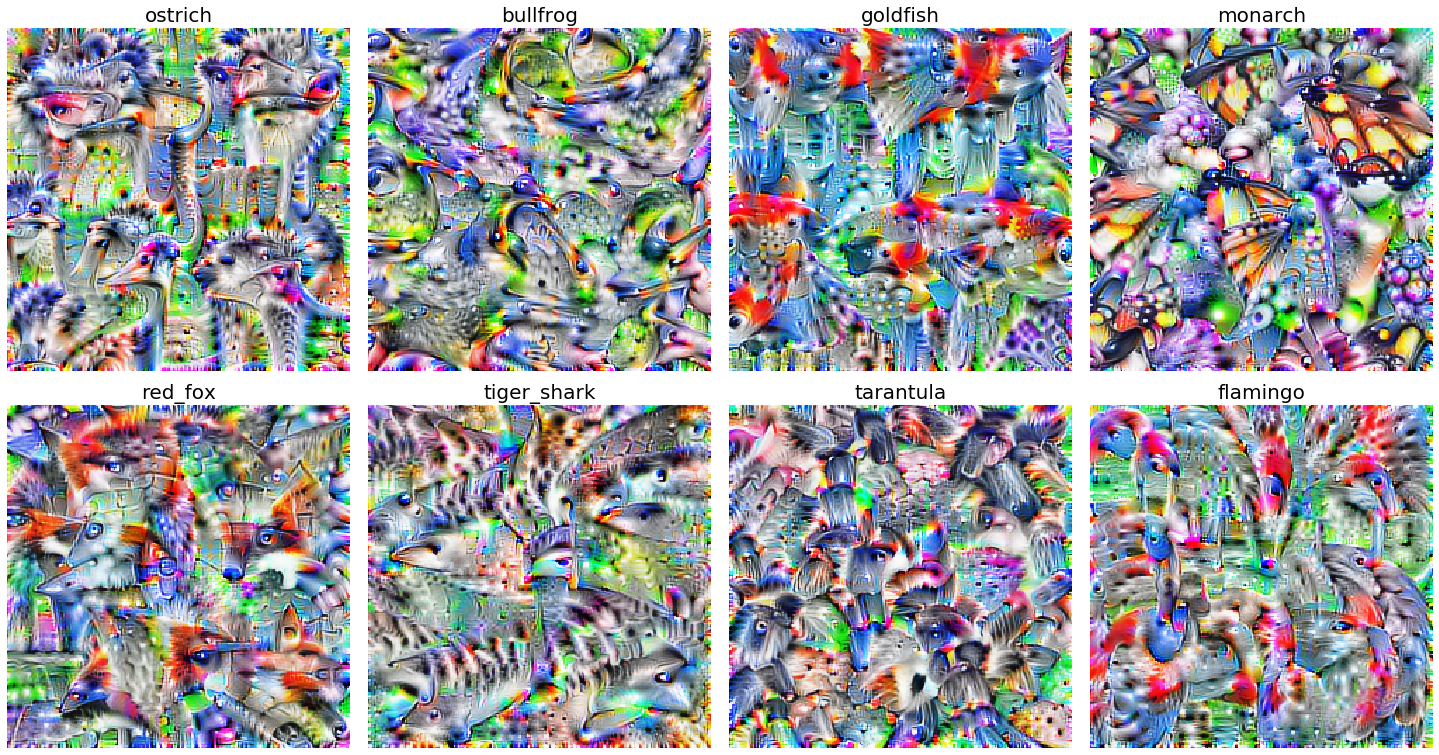

In [18]:
display_features(output_images, filter_names, ncols=4, zoom = 5)

### Animate results

In [19]:
import matplotlib.animation as animation
from IPython.display import HTML

def animate_receptive_filters(output_images, ncols = 3, zoom = 5, filter_names = None, sat_exp=2.0, val_exp=1.0):
    ims_list = []
    nrows = int(np.ceil(len(output_images[-1]) / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 5))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0.01, wspace=0.01)
    for axi, ax in enumerate(axs.flatten()):
        if axi < len(output_images[-1]):
            if filter_names is not None:
                ax.text(
                    0.5,
                    0.9,
                    filter_names[axi],
                    fontsize=20,
                    horizontalalignment="center",
                    ha="center",
                    va="center",
                    bbox=dict(
                        boxstyle="round", ec=(1.0, 1.0, 1.0, 0.5), fc=(1.0, 1.0, 1.0, 0.5),
                    ),
                    transform=ax.transAxes,
                )
        ax.axis("off")
    for frame in tqdm(range(len(output_images))):

        frame_list = []
        for i in range(len(output_images[-1])):
            ax = axs.flatten()[i]
            rgb = adjust_hsv(output_images[frame][i], sat_exp = sat_exp, val_exp = val_exp)
            pt = ax.imshow(rgb)
            frame_list.append(pt)
        ims_list.append(frame_list)

    ani = animation.ArtistAnimation(fig, ims_list, interval=int(1000/24), blit=True,
                                repeat_delay=1000)

    plt.close()
    return ani

In [20]:
ani = animate_receptive_filters(output_images, ncols = 4, zoom = 5, filter_names = filter_names)

In [21]:
#HTML(ani.to_jshtml())

#### save animation

In [22]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=None)

ani.save('classes.mp4', writer=writer)